### 运行环境简介
![image.png](img.png)<br>
点击运行，运行代码块，其修改会写入内存且不会因为代码块运行结束而释放，例如有两个代码块
```python
msg = "Hello World"
```
```python
print(msg)
```
先运行代码块 1 再运行代码块 2 会正常输出 "Hello World"<br>
先运行代码块 2 再运行代码块 1 会提示 msg 变量未定义<br>
当前代码块访问的内存会受前面执行过代码块的影响
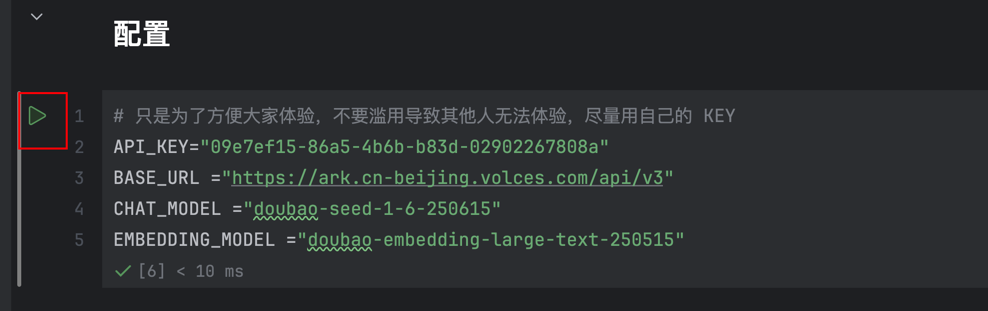

### 配置定义

In [ ]:
# 只是为了方便大家体验，不要滥用导致其他人无法体验，尽量用自己的 KEY
API_KEY="09e7ef15-86a5-4b6b-b83d-02902267808a"
BASE_URL ="https://ark.cn-beijing.volces.com/api/v3"
CHAT_MODEL ="doubao-seed-1-6-250615"
EMBEDDING_MODEL ="doubao-embedding-large-text-250515"

### 定义工具

In [ ]:
import requests

# 基础聊天工具
# msg 输入消息 必选
# history 历史消息 可选
# summary 消息摘要 可选
# matches RAG 召回 可选
def chat(msg,history=None,summary=None,matches=None):
    messages = [{
        "role": "system",
        "content": "You are a helpful assistant.",
    }]
    if history is not None:
        messages.extend(history)
    if summary is not None:
        messages[0]["content"]+=f" History messages summary:\n{summary}"
    if matches is not None:
        note = ""
        for match in matches:
            note += f"\n{match['role']}: {match['content']}"
        messages[0]["content"]+=f" Related history messages:{note}"
    messages.append({
        "role": "user",
        "content": msg,
    })
    resp = requests.post( # 主要就是拼接参数通过 HTTP 调用大模型
        url=f"{BASE_URL}/chat/completions",
        headers={'Content-Type': 'application/json', 'Authorization': f"Bearer {API_KEY}"},
        json={
            "model": CHAT_MODEL,
            "messages":messages,
        },
    )
    data = resp.json()
    return data['choices'][0]['message']['content']

# 摘要工具
# history 历史信息 必选
# summary 历史摘要 可选
def summary(history,summary=""):
    lines=""
    for msg in history:
        lines += f"{msg['role']}: {msg['content']}\n"
    # 拼接内容让大模型帮忙摘要
    res= chat(f"""请根据历史总结内容与新的对话内容生成新的总结用于后续记忆摘要

历史总结内容：
{summary}

新的对话内容：
{lines}""")
    return res

# 特征向量获取工具
# text 输入文本 必选
def embedding(text):
    resp = requests.post( # 通过 HTTP 调用向量特征模型
        url=f"{BASE_URL}/embeddings",
        headers={'Content-Type': 'application/json', 'Authorization': f"Bearer {API_KEY}"},
        json={
            "model": EMBEDDING_MODEL,
            "input":text,
        },
    )
    data = resp.json()
    return data['data'][0]['embedding']

### 测试工具

In [ ]:
print(chat("你好呀！")) # 测试 基础聊天工具

In [ ]:
print(summary([{   # 测试 摘要工具
    'role': 'user',
    'content':'你在干什么？',
},{
    'role': 'assistant',
    'content':'今天疯狂星期四，V 我 50',
}]))

In [ ]:
data = embedding("小狗") # 测试 特征向量获取工具
print(len(data))
print(data[:9])

#### 相同输入与相同模型测试

In [ ]:
for i in range(3):
    print(chat("你好"))

#### 记忆测试

In [ ]:
print(chat("你好，我叫邵康！"))
print(chat("你知道我叫什么吗？"))

#### 携带全部历史记录

In [ ]:
history =[]
while True:
    msg = input()
    if msg == "exit":
        break
    print(f"用户:{msg}")
    content = chat(msg=msg,history=history)
    print(f"AI:{content}")
    history.extend([{  # 收集全部历史消息
        "role": "user",
        "content": msg,
    },{
        "role": "assistant",
        "content": content,
    }])

#### 只保留最近 n 条历史记录

In [ ]:
history =[]
n = 4    # 携带最近 n 条历史消息
while True:
    msg = input()
    if msg == "exit":
        break
    print(f"用户:{msg}")
    content = chat(msg=msg,history=history)
    print(f"AI:{content}")
    history.extend([{
        "role": "user",
        "content": msg,
    },{
        "role": "assistant",
        "content": content,
    }])
    while len(history) > n:  # 超出 n 条丢弃最老的
        history.pop(0)

#### 相似度召回

In [ ]:
def get_vec_dot(v1,v2):  # 获取向量 点乘
    res =0
    for i in range(len(v1)):
        res += v1[i]*v2[i]
    return res

def get_best_match(msg,n=2):
    emb = embedding(msg) # 获取输入内容的特征向量
    arr =[]
    for item in history: # 收集输入与每个历史消息的特征向量点乘  与 对应的历史消息
        arr.append((get_vec_dot(item["embedding"],emb),item))
    arr.sort(key=lambda x:x[0],reverse=True) # 按相似度排序
    res =[]
    num = min(n,len(arr))
    for i in range(num): # 获取最相似的 n 条
        print(f"{i+1}\t{arr[i][0]}\t{arr[i][1]['role']}\t{arr[i][1]['content']}")
        res.append(arr[i][1])
    return res

history=[]
while True:
    msg = input()
    if msg == "exit":
        break
    print(f"用户:{msg}")
    matches = get_best_match(msg)
    content = chat(msg=msg,matches=matches)
    print(f"AI:{content}")
    history.extend([{
        "role": "user",
        "content": msg,
        "embedding":embedding(msg), # 历史消息计算一次特征向量保存，后续不再计算
    },{
        "role": "assistant",
        "content": content,
        "embedding":embedding(content),
    }])

#### 历史记录摘要

In [ ]:
summary_str=""
while True:
    msg = input()
    if msg == "exit":
        break
    print(f"用户:{msg}")
    content = chat(msg=msg,summary=summary_str)
    print(f"AI:{content}")
    summary_str=summary([{
        "role": "user",
        "content": msg,
    },{
        "role": "assistant",
        "content": content,
    }],summary_str)
    print(f"summary:{summary_str}")

#### LoRA 微调
这一块需要的背景知识较多且一般记忆的实现都是不会动模型参数的，因此不做重点，大概体验一下就行（从上到下挨个执行代码块）

In [ ]:
from torch.nn import Module,Linear,Parameter
import torch

# 定义 LoRA 一般 LoRA 微调是用专门的库，这里手搓 LoRA 增强记忆
class LoRALinear(Module): # 对原有 Linear 的 LoRA 增强
    def __init__(self,linear:Linear,rank,rate):
        super().__init__()
        self.linear = linear # 原始逻辑
        self.rate = rate # LoRA 作用程度
        # 低阶矩阵参数
        self.A = Parameter(torch.randn(linear.in_features,rank))
        self.B = Parameter(torch.randn(rank,linear.out_features))

    def forward(self, x):
        lora = x @ (self.A @ self.B)  # a@b 得到与 linear 同样格式大小的线性系数 再与原始数据 x 得到线性后的值
        return self.linear(x)+lora*self.rate # 原始值 + 外挂的 LoRA

In [18]:
from transformers import BertTokenizer
from transformers import BertModel

# 加载我们要微调的模型   需要访问 huggingface 下载模型 需要确保 huggingface 可用访问
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese') # 加载预训练模型分词器
llm = BertModel.from_pretrained('bert-base-chinese') # 加载预训练模型，参数已经加载到模型内了

for param in llm.parameters():
    param.requires_grad = False   # 原模型不需要调整关闭求导
for layer in llm.encoder.layer:   # 对我们要微调的部分使用 LoRA 包装
    layer.attention.self.query = LoRALinear(layer.attention.self.query,2,0.05)
    layer.attention.self.value = LoRALinear(layer.attention.self.value,2,0.05)

# 包转原模型使其生成文本概率
class BertWithOutputLayer(Module):
    def __init__(self, bert_model, vocab_size):
        super().__init__()
        self.bert = bert_model
        # 添加线性层：将hidden_size（768）映射到vocab_size
        self.output_layer = Linear(768, vocab_size)

    def forward(self,input_ids,attention_mask,token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,token_type_ids=token_type_ids)
        last_hidden_state = outputs.last_hidden_state  # 取最后一层隐藏状态
        # 通过线性层映射到词表大小：(batch_size, seq_len, vocab_size)
        logits = self.output_layer(last_hidden_state)
        return logits

llm = BertWithOutputLayer(llm, tokenizer.vocab_size)
total_params = 0
for param in llm.parameters():
    # 累加每个参数张量的元素个数
    total_params += param.numel()
print('change_llm:',llm)
print('parameter_len',total_params)

change_llm: BertWithOutputLayer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): LoRALinear(
                (linear): Linear(in_features=768, out_features=768, bias=True)
              )
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): LoRALinear(
                (linear): Linear(in_features=768, out_features=768, bias=True)
              )
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (de

| ![图片1](img_1.png) | ![图片2描述](img_2.png) |
| --- | --- |

为了加快训练速度，推荐切换到 GPU
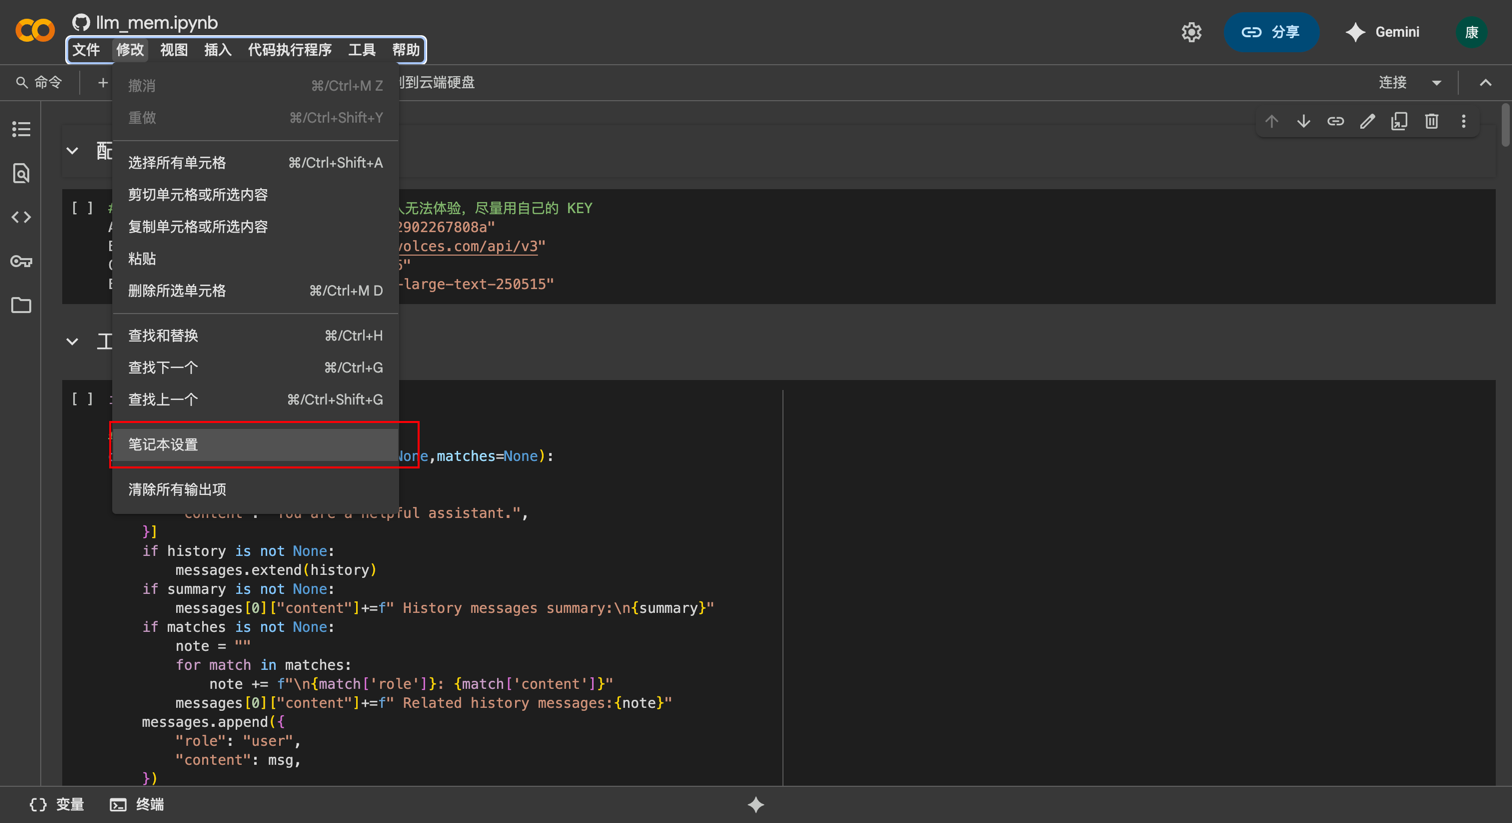
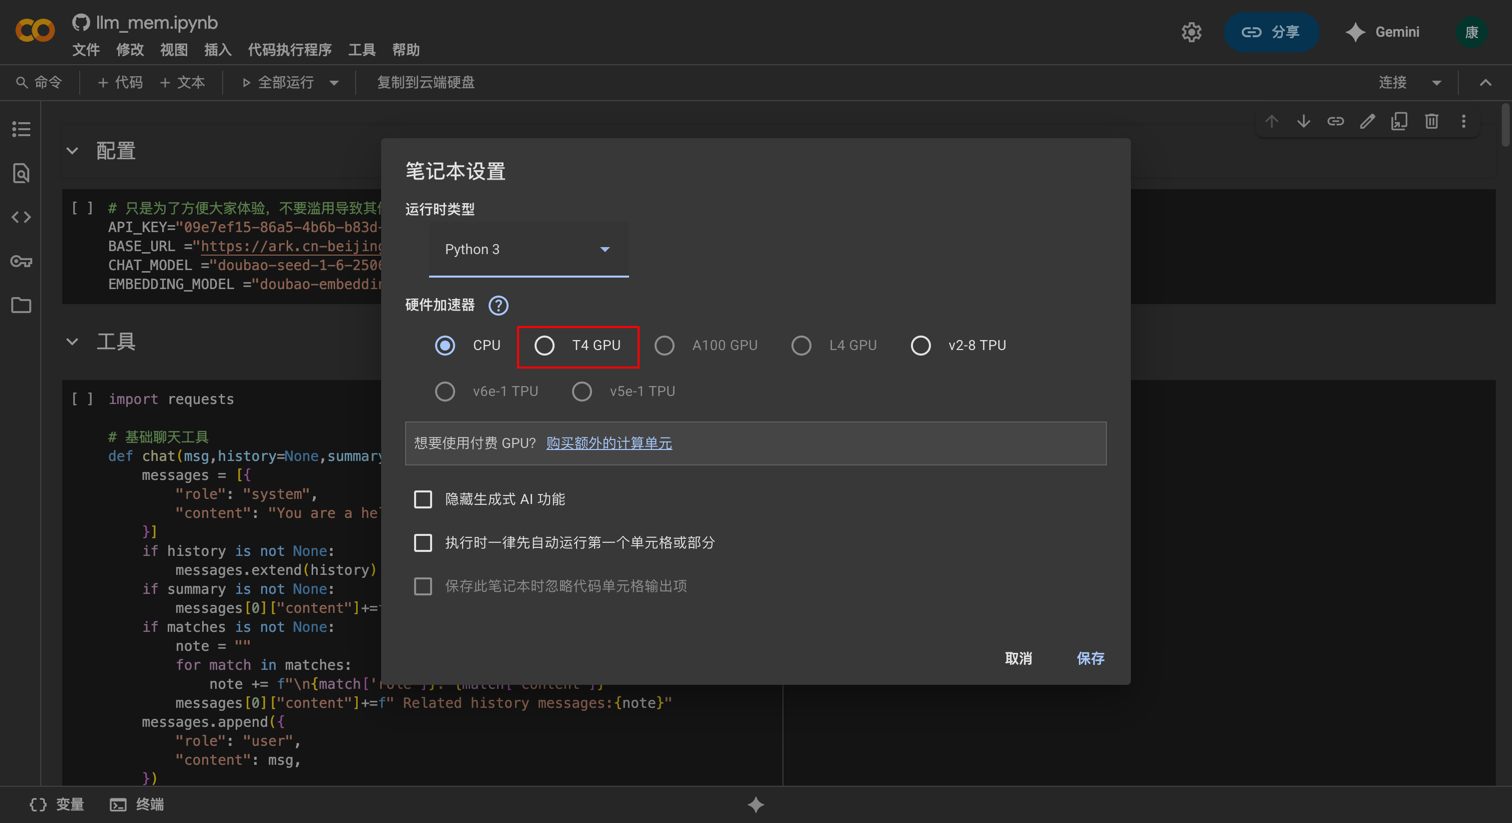

In [19]:
import torch

device ="cpu" # 默认使用 cpu
if torch.backends.mps.is_available():
    device = "mps" # mac 上使用的  mps 可用
if torch.cuda.is_available():
    device = "cuda" # N卡使用   cuda 可用
print(f'using {device} device')
llm.to(device)  # 使用加速设备

using mps device


BertWithOutputLayer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): LoRALinear(
                (linear): Linear(in_features=768, out_features=768, bias=True)
              )
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): LoRALinear(
                (linear): Linear(in_features=768, out_features=768, bias=True)
              )
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear

In [20]:
from torch.optim import AdamW
import torch.nn.functional as F

# 随便找一条历史进行微调演示
history = "[CLS]我是邵康，我最喜欢玩原神了[SEP]"

optimizer = AdamW(llm.parameters(), lr=3e-4) # 定义优化器
epoch = 100
loss_arr =[]
for item in range(epoch): # 训练 100 轮
    token = tokenizer([history],return_tensors="pt") # 分词   return_tensors="pt" 指定返回 torch.tensor 格式
    token=token.to(device)
    out = llm(input_ids=token.input_ids,attention_mask=token.attention_mask,token_type_ids=token.token_type_ids)
    size= token.input_ids.shape[1]
    prob = out[:,:size-1,:].view(size-1,-1) # n * 21128
    res = token.input_ids[:,1:].view(-1) #  n
    loss = F.cross_entropy(prob, res) # 计算交叉熵
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # 调整参数
    loss_arr.append(loss.item()) # 收集损失值

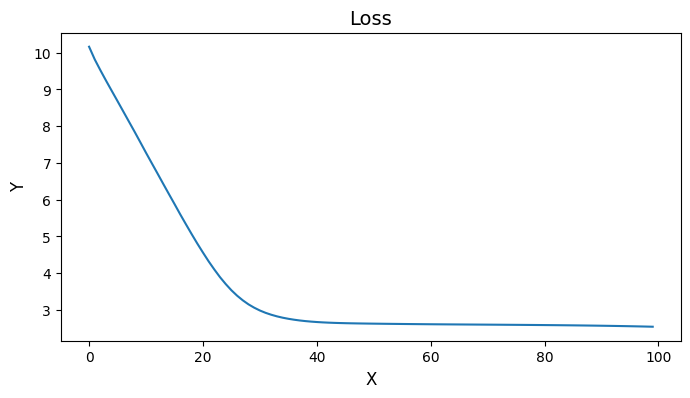

In [21]:
import matplotlib.pyplot as plt

# 绘制训练过程中 模型与标准答案的偏差值
plt.figure(figsize=(8, 4))  # 设置画布大小，宽8英寸，高4英寸
plt.plot(list(range(len(loss_arr))), loss_arr)  # 核心函数：plot(x轴数据, y轴数据)
plt.xlabel('X', fontsize=12)  # x轴标签
plt.ylabel('Y', fontsize=12)  # y轴标签
plt.title('Loss', fontsize=14)  # 图表标题
plt.show()

In [22]:
print(tokenizer.model_max_length) # 最大上下文长度  512
def generate(str,max_len=256): # 总长度尽量不要超过 512
    for i in range(max_len):
        token = tokenizer([str],return_tensors="pt") # 分词   return_tensors="pt" 指定返回 torch.tensor 格式
        token=token.to(device)
        res = llm(input_ids=token.input_ids,attention_mask=token.attention_mask,token_type_ids=token.token_type_ids)
        res = F.softmax(res, dim=-1)
        size = res.shape[1]
        res =res[:,size-1:].view(-1)   # 只要预测的最后一个词即可
        res = torch.multinomial(res, num_samples=1)
        res= tokenizer.decode(res) # 解码为中文
        str+=res # 添加进字符串用于下轮预测
    return str  # 返回最终结果

# 测试训练结果，用模型进行补全
print(generate("我是",max_len=32))

512
我是##cca我裤濺204喜f4神最##疵[SEP]2015##ces邵邵[SEP]玩我邵[SEP]玩##鑰##计##蹟##県[CLS]邵欢是玩喜邵
